**Import Desired Packages and Mount Drive**

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Process the Dataset from Webscraping**

In [ ]:
df = pd.read_excel('/content/drive/My Drive/updated_df.xlsx')
df = (df.dropna()).reset_index()

In [ ]:
for i in range(len(df)):
  df['genres'][i] = int(re.split(r"\:(.*?)\,", df['genres'][i])[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Compute Subjectivity Scores**

In [ ]:
subjectivity = []
for i in range(len(df)):
  s = (df['positive_sentiment'][i] + df['negative_sentiment'][i])/df['neutral_sentiment'][i]
  subjectivity.append(s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [ ]:
# Join subjectivity scores to the initial dataset
df = df.join(pd.DataFrame(subjectivity, columns=['subjectivity']), how='outer')

**Bin the Movies According to PM**

In [ ]:
# Create Target Bin Column
df = df.sort_values(by=['target'])
df['target_bin'] = df['target']
df = df.dropna()
df = df.reset_index()

In [ ]:
# Bin the movies accordingly
for i in range(0, len(df)):
  if df['target'][i] < 1.24 * df['budget'][i]:
    df['target_bin'][i] = 0
  else:
    df['target_bin'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


**Specify Features and Split the Dataset**

In [ ]:
# Specify desired features
feature_list = ['subjectivity', 'views', 'likes', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment']

# Separate X and y
X = df[feature_list]
y = df[['target_bin']]

# Normalize Features
X = (X-X.min())/(X.max()-X.min())
n_df = X.join(y, how='outer')

train, temp = train_test_split(n_df, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# Specify train, test, validation
train_X = train.drop(columns = 'target_bin')
train_y = train['target_bin']
val_X = val.drop(columns = 'target_bin')
val_y = val['target_bin']
test_X = test.drop(columns = 'target_bin')
test_y = test['target_bin']

**Explore the Dataset**

Text(0.5, 0, 'Likes')

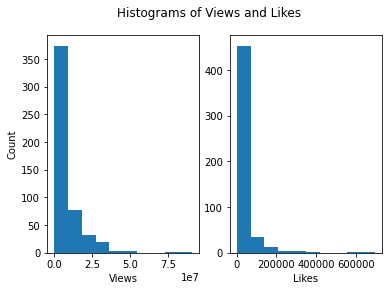

In [ ]:
# Generate Histograms of Views and Likes on Each Movie
views_count = df['views']
likes_count = df['likes']

fig, ax = plt.subplots(1, 2)
fig.suptitle('Histograms of Views and Likes')

ax[0].hist(views_count)
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Views')
ax[1].hist(likes_count)
ax[1].set_xlabel('Likes')

Text(0.5, 15.0, 'Neutral Sentiment')

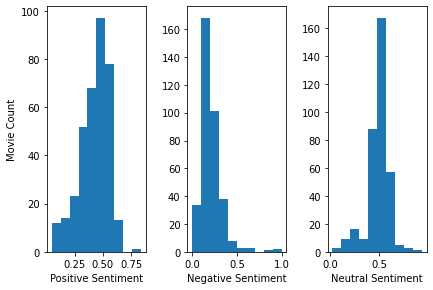

In [ ]:
# Generate histograms of average positive sentiment, average negative sentiment and average neutral sentiment
pos = sorted(train['positive_sentiment'])
neg = sorted(train['negative_sentiment'])
neu = sorted(train['neutral_sentiment'])


fig, ax = plt.subplots(1, 3)
plt.tight_layout()

ax[0].hist(pos)
ax[0].set_xlabel('Positive Sentiment')
ax[0].set_ylabel('Movie Count')
ax[1].hist(neg)
ax[1].set_xlabel('Negative Sentiment')
ax[2].hist(neu)
ax[2].set_xlabel('Neutral Sentiment')

([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

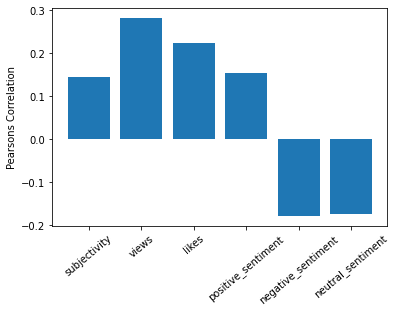

In [ ]:
# Compute the Pearson's correlation of each feature with the target bin
features = ['subjectivity', 'views', 'likes', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment']
pearsons = []

for feature in features:
  pearsons.append(pearsonr(train['target_bin'], train[feature])[0])

plt.bar(features, pearsons)
plt.ylabel('Pearsons Correlation')
plt.xticks(rotation = 40)

Text(0.5, 1.0, 'Distribution of Profitability Multiples')

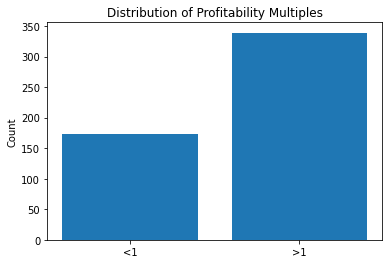

In [ ]:
# Observe distribution of target bin
plt.bar(['<1', '>1'], 
        [df[df['target_bin']==0].count()[0], 
         df[df['target_bin']==1].count()[0]])
plt.ylabel('Count')
plt.title('Distribution of Profitability Multiples')

In [ ]:
# Resample the dataset using SMOTE to have balanced classes
smote = SMOTE()
x_res, y_res = smote.fit_resample(train_X, train_y)

**Build the Models**

In [ ]:
# Specify scoring dictionary
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score)}

In [ ]:
# Use helper function for confusion matrix visualization
def confusion(pred, actual):
    confusion = confusion_matrix(actual, pred)
    plt.subplot()
    sns.heatmap(confusion, annot=True, fmt='g');
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

In [ ]:
# Run Logistic Regression w 5-fold cross-validation
lr = LogisticRegression(penalty = 'l2', max_iter = 1000)
print(np.mean(cross_validate(lr, x_res, y_res, cv=5, scoring=scoring)['test_accuracy']))
print(np.mean(cross_validate(lr, x_res, y_res, cv=5, scoring=scoring)['test_precision']))
print(np.mean(cross_validate(lr, x_res, y_res, cv=5, scoring=scoring)['test_recall']))

0.6569158075601373
0.6730152762284258
0.6074829931972789


Text(0.5, 1.0, 'Accuracy vs K')

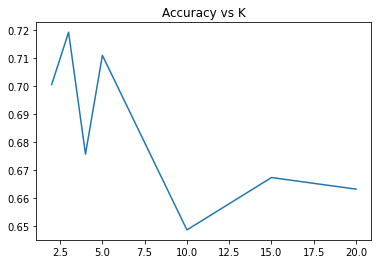

In [ ]:
# Generate accuracy with different K nearest neighbors on 5-fold cross-validation
k_values = [2, 3, 4, 5, 10, 15, 20]

accuracies = {}
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracies[k] = np.mean(cross_val_score(knn, x_res, y_res, cv=5))

plt.plot(list(accuracies.keys()), list(accuracies.values()))
plt.title('Accuracy vs K')

In [ ]:
# Run KNN w 5-fold cross-validation using the specified value of K
knn = KNeighborsClassifier(n_neighbors=25)
print(np.mean(cross_validate(knn, x_res, y_res, cv=5, scoring=scoring)['test_accuracy']))
print(np.mean(cross_validate(knn, x_res, y_res, cv=5, scoring=scoring)['test_precision']))
print(np.mean(cross_validate(knn, x_res, y_res, cv=5, scoring=scoring)['test_recall']))

0.7190936426116838
0.8061689018210758
0.5908163265306123


Text(0.5, 1.0, 'Accuracy vs Depth')

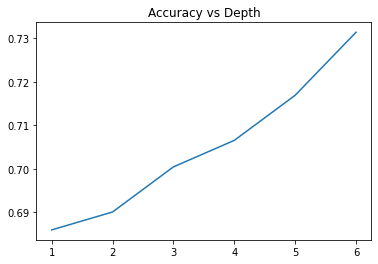

In [ ]:
# Generate accuracy at different depths on cross-validation
depths = [1,2,3,4,5,6]
accuracies = {}
for d in depths:
    rf = RandomForestClassifier(max_depth=d)
    accuracies[d] = np.mean(cross_val_score(rf, x_res, y_res, cv=5))
plt.plot(list(accuracies.keys()), list(accuracies.values()))
plt.title('Accuracy vs Depth')

In [ ]:
# Run Random Forest w 5-fold cross-validation using the specified value of depth
rf = RandomForestClassifier(max_depth=6)
print(np.mean(cross_validate(rf, x_res, y_res, cv=5, scoring=scoring)['test_accuracy']))
print(np.mean(cross_validate(rf, x_res, y_res, cv=5, scoring=scoring)['test_precision']))
print(np.mean(cross_validate(rf, x_res, y_res, cv=5, scoring=scoring)['test_recall']))

0.733483676975945
0.807954150804782
0.6446428571428571


In [ ]:
# Run Linear Support Vector Machine with 5-fold Cross-validation
sm = SVC()
print(np.mean(cross_validate(sm, x_res, y_res, cv=5, scoring=scoring)['test_accuracy']))
print(np.mean(cross_validate(sm, x_res, y_res, cv=5, scoring=scoring)['test_precision']))
print(np.mean(cross_validate(sm, x_res, y_res, cv=5, scoring=scoring)['test_recall']))

0.675536941580756
0.7460231896118994
0.5326530612244899


In [ ]:
# Run Gaussian Naive Bayes with 5-fold Cross-validation
gnb = GaussianNB()
print(np.mean(cross_validate(gnb, x_res, y_res, cv=5, scoring=scoring)['test_accuracy']))
print(np.mean(cross_validate(gnb, x_res, y_res, cv=5, scoring=scoring)['test_precision']))
print(np.mean(cross_validate(gnb, x_res, y_res, cv=5, scoring=scoring)['test_recall']))

0.6610824742268041
0.8511880711880713
0.3923469387755102


**Test Chosen Model on the Test Set**

              precision    recall  f1-score   support

           0       0.81      0.71      0.75        41
           1       0.71      0.81      0.75        36

    accuracy                           0.75        77
   macro avg       0.76      0.76      0.75        77
weighted avg       0.76      0.75      0.75        77



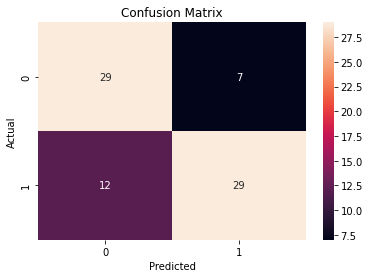

In [ ]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(x_res, y_res)
pred_y = knn.predict(test_X)

print(classification_report(pred_y, test_y))
confusion(pred_y, test_y)

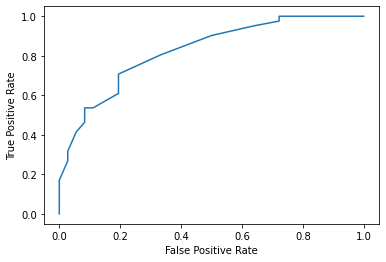

In [ ]:
# Display ROC curve
probs_y = knn.predict_proba(test_X)[:, 1]
fpr, tpr, threshold = roc_curve(test_y, probs_y)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

**Reperform Training using Augmented Dataset**

In [ ]:
# Specify Genres as one of 4 classes ['Horror', 'Drama', 'Action', 'Other']
genres_df = df
for i in range(len(df)):
  if df['genres'][i] == 14:
    genres_df['genres'][i] = 0
    continue
  if df['genres'][i] == 18:
    genres_df['genres'][i] = 1
    continue
  if df['genres'][i] == 28 or df['genres'][i] == 12:
    genres_df['genres'][i] = 2
    continue
  else:
    genres_df['genres'][i] = 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dis

In [ ]:
# Use TensorFlow to one-hot-encode these categories into a vector
genres = to_categorical(genres_df['genres'])
genres_df = pd.DataFrame(genres, columns=['Horror', 'Drama', 'Action', 'Other'])

In [ ]:
# Join the DataSet
df = df.join(genres_df, how='outer')

In [ ]:
# Specify features for augmented dataset (namely the original dataset with the inclusion of 4 one-hot-encoded genre categories)
feature_list = ['subjectivity', 'views', 'likes', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 'Horror', 'Drama', 'Action', 'Other']

X = df[feature_list]
y = df[['target_bin']]

X = (X-X.min())/(X.max()-X.min())
n_df = X.join(y, how='outer')

train, temp = train_test_split(n_df, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

train_X = train.drop(columns = 'target_bin')
train_y = train['target_bin']
val_X = val.drop(columns = 'target_bin')
val_y = val['target_bin']
test_X = test.drop(columns = 'target_bin')
test_y = test['target_bin']

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

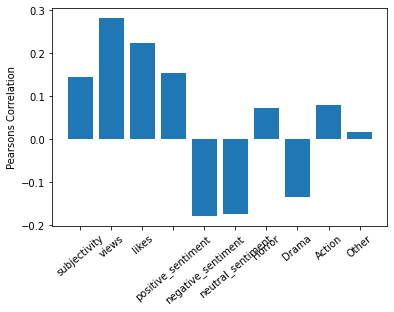

In [ ]:
# Recheck Pearson's correlations
features = ['subjectivity', 'views', 'likes', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 'Horror', 'Drama', 'Action', 'Other']
pearsons = []

for feature in features:
  pearsons.append(pearsonr(train['target_bin'], train[feature])[0])

plt.bar(features, pearsons)
plt.ylabel('Pearsons Correlation')
plt.xticks(rotation = 40)

In [ ]:
# Resample the dataset using SMOTE
smote = SMOTE()
x_res, y_res = smote.fit_resample(train_X, train_y)

In [ ]:
# Run Logistic Regression w 5-fold cross-validation
print(np.mean(cross_validate(lr, x_res, y_res, cv=5, scoring=scoring)['test_accuracy']))
print(np.mean(cross_validate(lr, x_res, y_res, cv=5, scoring=scoring)['test_precision']))
print(np.mean(cross_validate(lr, x_res, y_res, cv=5, scoring=scoring)['test_recall']))

0.6942225085910653
0.7098746358471759
0.6609693877551022


Text(0.5, 1.0, 'Accuracy vs K')

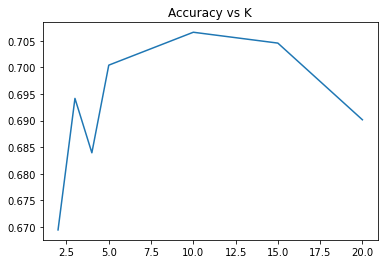

In [ ]:
# Generate accuracy with different K nearest neighbors on 5-fold cross-validation
k_values = [2, 3, 4, 5, 10, 15, 20]

accuracies = {}
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracies[k] = np.mean(cross_val_score(knn, x_res, y_res, cv=5))

plt.plot(list(accuracies.keys()), list(accuracies.values()))
plt.title('Accuracy vs K')

In [ ]:
# Run KNN w 5-fold cross-validation using the specified value of K
knn = KNeighborsClassifier(n_neighbors=10)
print(np.mean(cross_validate(knn, x_res, y_res, cv=5, scoring=scoring)['test_accuracy']))
print(np.mean(cross_validate(knn, x_res, y_res, cv=5, scoring=scoring)['test_precision']))
print(np.mean(cross_validate(knn, x_res, y_res, cv=5, scoring=scoring)['test_recall']))

0.7065936426116839
0.8208924217544908
0.5370748299319728


Text(0.5, 1.0, 'Accuracy vs Depth')

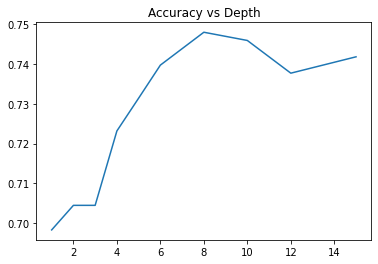

In [ ]:
# Generate accuracy at different depths on cross-validation
depths = [1,2,3,4,5,6,8,10,12,15]
accuracies = {}
for d in depths:
    rf = RandomForestClassifier(max_depth=d)
    accuracies[d] = np.mean(cross_val_score(rf, x_res, y_res, cv=5))
plt.plot(list(accuracies.keys()), list(accuracies.values()))
plt.title('Accuracy vs Depth')

In [ ]:
# Run Random Forest w 5-fold cross-validation using the specified value of depth
rf = RandomForestClassifier(max_depth=8)
print(np.mean(cross_validate(rf, x_res, y_res, cv=5, scoring=scoring)['test_accuracy']))
print(np.mean(cross_validate(rf, x_res, y_res, cv=5, scoring=scoring)['test_precision']))
print(np.mean(cross_validate(rf, x_res, y_res, cv=5, scoring=scoring)['test_recall']))

0.7376073883161512
0.807494873547505
0.6446428571428571


In [ ]:
# Run Linear Support Vector Machine with 5-fold Cross-validation
sm = SVC()
print(np.mean(cross_validate(sm, x_res, y_res, cv=5, scoring=scoring)['test_accuracy']))
print(np.mean(cross_validate(sm, x_res, y_res, cv=5, scoring=scoring)['test_precision']))
print(np.mean(cross_validate(sm, x_res, y_res, cv=5, scoring=scoring)['test_recall']))

0.65713058419244
0.6870178121870009
0.6074829931972789


In [ ]:
# Run Gaussian Naive Bayes with 5-fold Cross-validation
gnb = GaussianNB()
print(np.mean(cross_validate(gnb, x_res, y_res, cv=5, scoring=scoring)['test_accuracy']))
print(np.mean(cross_validate(gnb, x_res, y_res, cv=5, scoring=scoring)['test_precision']))
print(np.mean(cross_validate(gnb, x_res, y_res, cv=5, scoring=scoring)['test_recall']))

0.6549398625429552
0.86285153019024
0.3795918367346939


**Test Chosen Model on the Test Dataset**

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        42
           1       0.71      0.83      0.76        35

    accuracy                           0.77        77
   macro avg       0.77      0.77      0.77        77
weighted avg       0.78      0.77      0.77        77



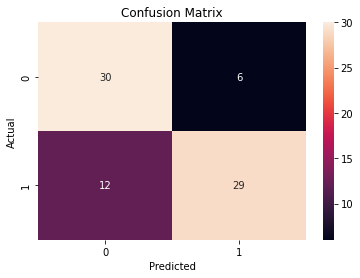

In [ ]:

rf = RandomForestClassifier(max_depth=4)
rf.fit(x_res, y_res)
pred_y = rf.predict(test_X)

print(classification_report(pred_y, test_y))
confusion(pred_y, test_y)

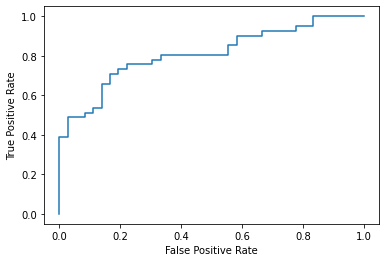

In [ ]:
# Display ROC curve
probs_y = rf.predict_proba(test_X)[:, 1]
fpr, tpr, threshold = roc_curve(test_y, probs_y)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
# Compute the Area under the Curve
print('Area under curve:', round(roc_auc_score(test_y, probs_y),3))

Area under curve: 0.81
